# Procesamiento de imágenes · Tarea 4

En esta tarea nos enfocaremos en el procesamiento de imágenes en el espacio de la frecuencia usando la transformada de Fourier.

El programa está incompleto, por lo que deberás escribir tu propio código en las celdas que lo soliciten. Ejecuta las celdas en orden hasta llegar a una que debas rellenar. Una vez hayas escrito tu código, continúa ejecutando las celdas y asegúrate que no hayan alertas al correr los chequeos.

### Importante
* Lee atentamente las instrucciones y todo el código.
* Ejecuta las celdas en orden.
* Escribe tu código en las celdas que lo soliciten.
* Usa los nombres de variables que te pidan.
* Confirma que tu código esté correcto corriendo las celdas que dicen "Chequeo".
* Si el chequeo alerta que hay alguna variable incorrecta, vuelve atrás y arréglala. No hay penalización por esto.

### Configuración inicial

##### Importamos librerías

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

##### Aumentamos el tamaño de las imágenes

In [2]:
plt.rcParams['figure.dpi'] = 200

## Carga y visualización de la imagen

Cargamos y mostramos la primera imagen en escala de grises.

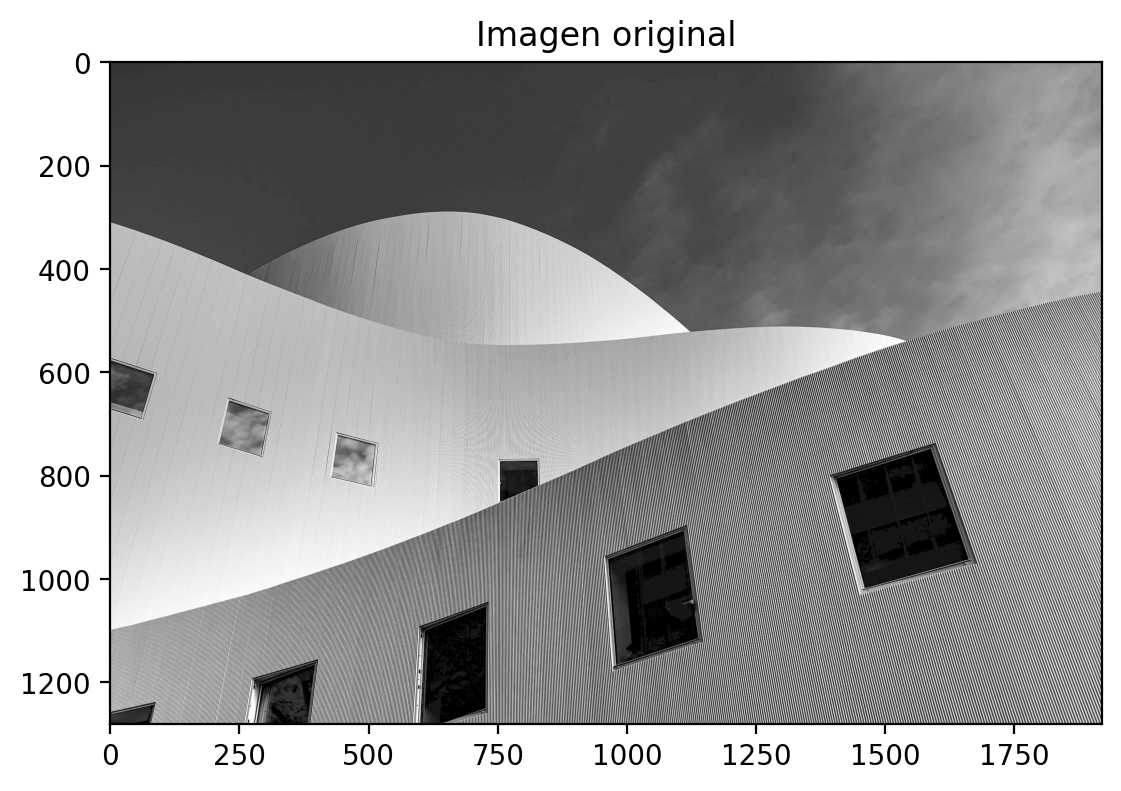

In [3]:
img_arch_path = 'architecture.png'
img_arch = cv2.imread(img_arch_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(img_arch, cmap='gray')
plt.title('Imagen original');

## Transformada de Fourier de la imagen

Queremos estudiar la imagen anterior en el dominio de la frecuencia.

**Calcula la transformada de Fourier discreta** de ```img_arch``` usando la función ```fft2``` de ```np.fft``` (más información [aquí](https://numpy.org/doc/stable/reference/generated/numpy.fft.fft2.html)). Luego, aplícale a lo obtenido la función ```fftshift``` de ```np.fft``` (más información [aquí](https://numpy.org/doc/stable/reference/generated/numpy.fft.fftshift.html)) para que la información de las frecuencias bajas queden al centro de la imagen. Guarda el resultado final en ```img_arch_fft```.

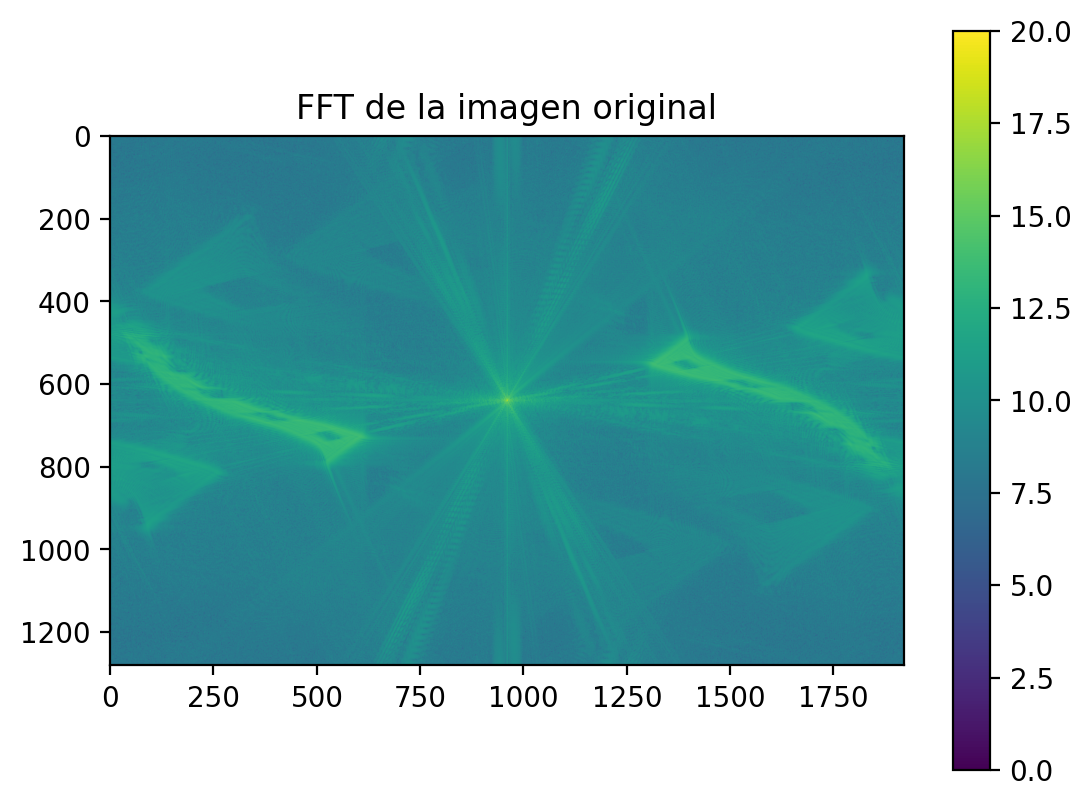

In [4]:
# Define img_arch_fft
img_arch_fft = np.fft.fftshift(np.fft.fft2(img_arch))
plt.imshow(np.log(np.absolute(img_arch_fft)), vmin=0, vmax=20)
plt.title('FFT de la imagen original')
plt.colorbar();

Vemos que la FFT (*fast Fourier transform*) de la foto contiene una gran cantidad de información, tanto en las frecuencias bajas como en las altas.

### Segmento de la imagen

Estudiemos un segmento de la imagen cercano a la ventana de más a la derecha.

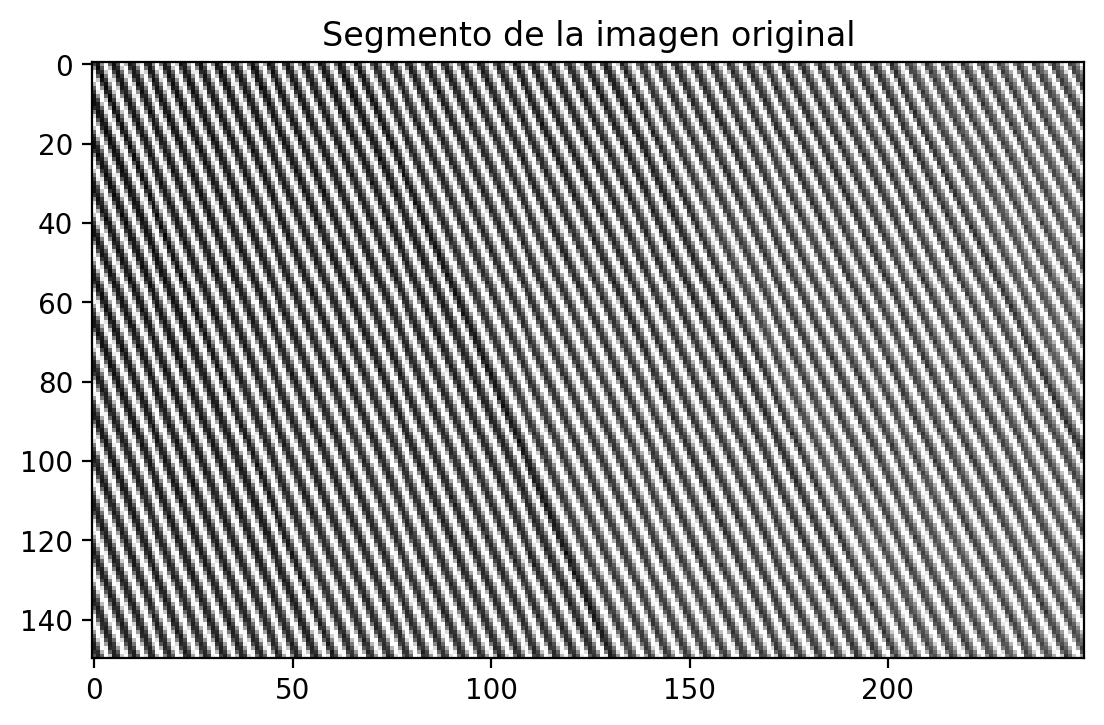

In [5]:
img_lines = img_arch[550:700, 1650:1900]
plt.imshow(img_lines, cmap='gray')
plt.title('Segmento de la imagen original');

La textura del edificio se muestra como delgadas líneas en la imagen.

### FFT del segmento de la imagen

Generemos la FFT de este segmento. ¿Cómo crees que se verá?

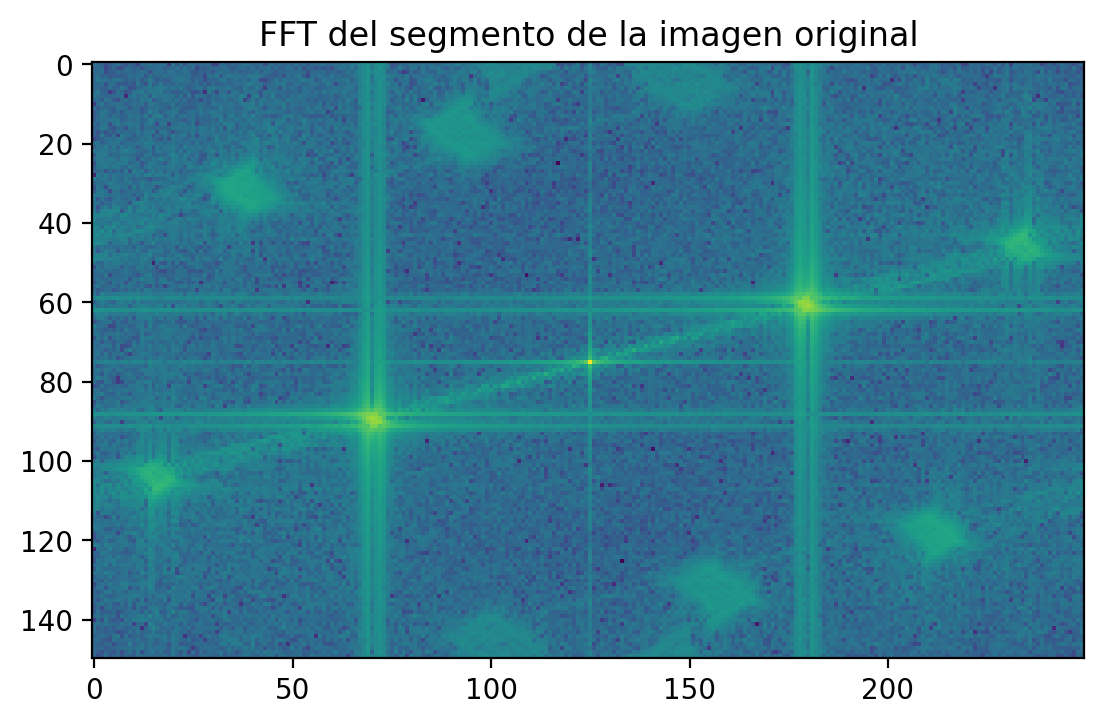

In [6]:
img_lines_fft = np.fft.fftshift(np.fft.fft2(img_lines))
plt.title('FFT del segmento de la imagen original')
plt.imshow(np.log(np.abs(img_lines_fft)));

Vemos dos grandes _peaks_ en la FFT que están relacionados a las líneas periódicas de la imagen.

Como la imagen no corresponde a sinusoides perfectas, también vemos otras frecuencias en la FFT.

### Pasabajos para eliminar las líneas

Apliquemos nuestros conocimientos del dominio de la frecuencia para suavizar la foto y así eliminar las líneas que vimos anteriormente.

Usaremos una Gaussiana para nuestra máscara pasabajos. La forma de esta dependerá de su sigma.

Escoge un valor de ```arch_sigma``` que elimine las líneas de alta frecuencia pero que permita que la imagen aún sea reconocible.

Si escoges un sigma muy bajo, eliminarás gran parte de la información y no entenderemos qué estamos viendo. Si escoges un sigma muy alto, no se eliminará suficiente información de las altas frecuencias y seguiremos viendo las líneas.

Prueba con distintos valores de ```arch_sigma```, estudiando las imágenes resultantes y sus FFT.

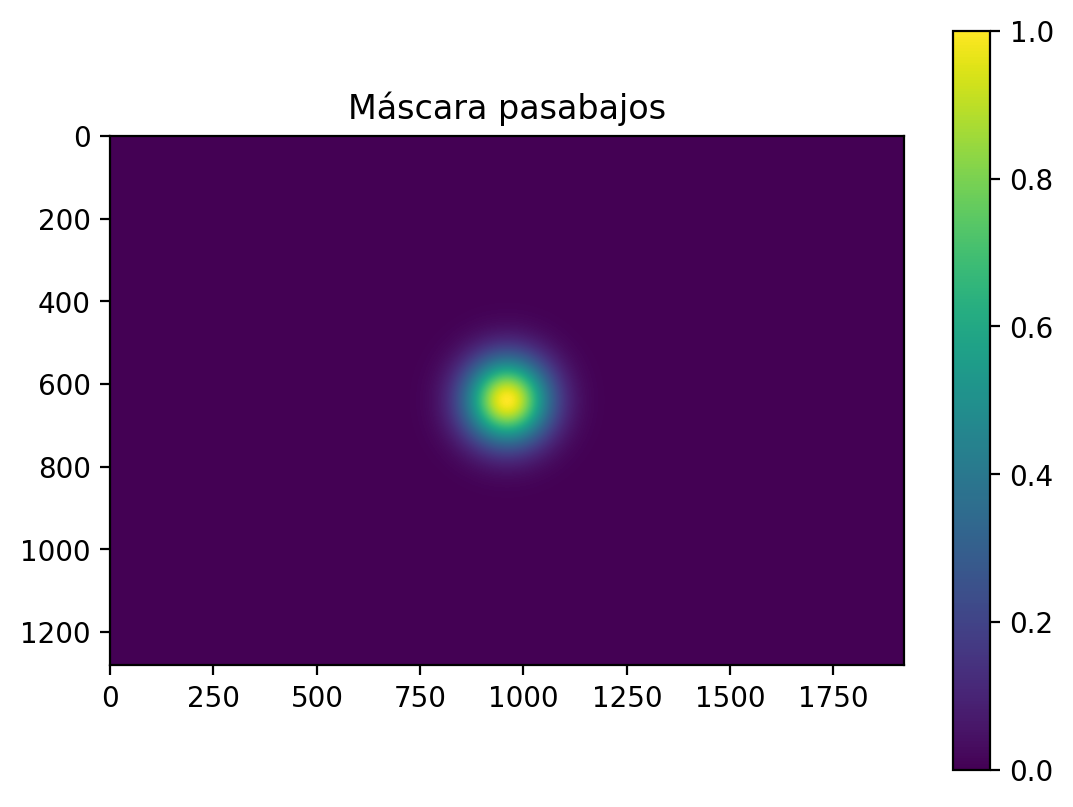

In [7]:
# Define arch_sigma
arch_sigma = 100
img_arch_size_y, img_arch_size_x = img_arch.shape
img_arch_center_y = img_arch_size_y // 2
img_arch_center_x = img_arch_size_x // 2

grid_x, grid_y = np.meshgrid(np.arange(img_arch_size_x), np.arange(img_arch_size_y))
lowpass_mask = np.exp(-(((grid_y - img_arch_center_y) / arch_sigma)**2
                        + ((grid_x - img_arch_center_x) / arch_sigma)**2))

plt.imshow(lowpass_mask)
plt.title('Máscara pasabajos')
plt.colorbar();

Multiplicamos la máscara con la FFT de la imagen.

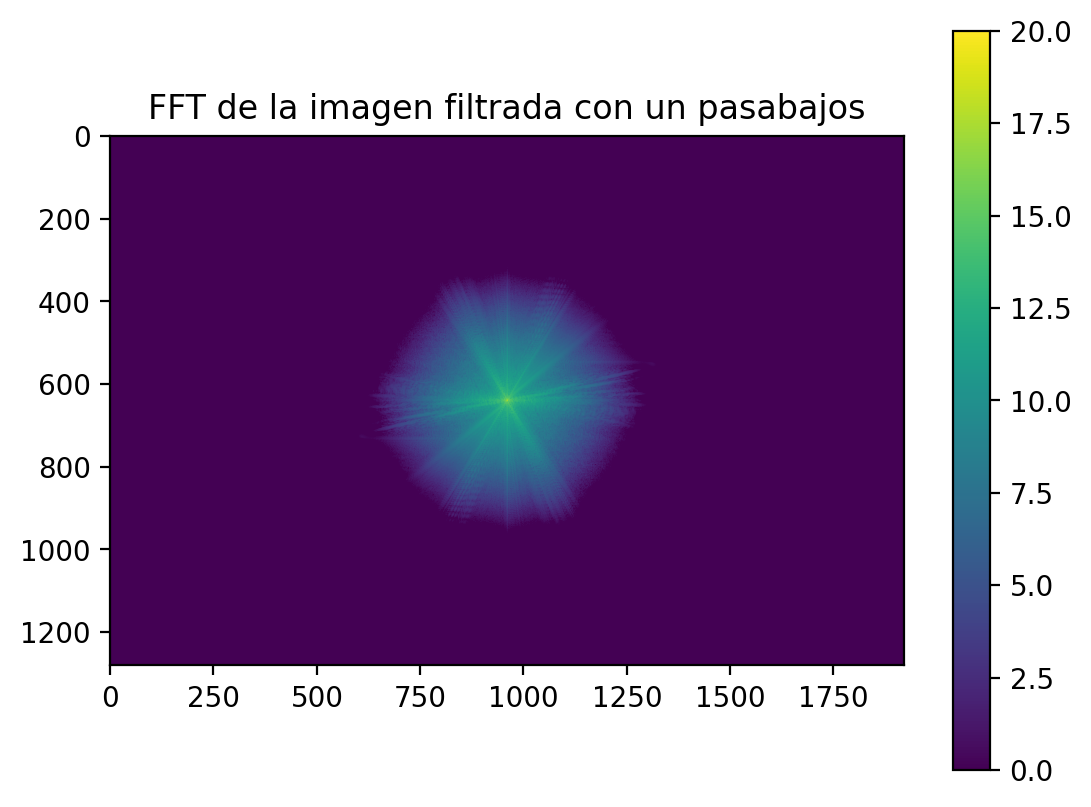

In [8]:
img_arch_fft_lowpass = img_arch_fft * lowpass_mask
plt.imshow(np.log(np.abs(img_arch_fft_lowpass)), vmin=0, vmax=20)
plt.title('FFT de la imagen filtrada con un pasabajos')
plt.colorbar();

En la gráfica anterior vemos que se eliminaron las altas frecuencias de la imagen, conservando solo las frecuencias cercanas al centro.

### Volviendo al dominio del espacio

Usamos ```ifft2``` de ```np.fft``` para volver al dominio del espacio.

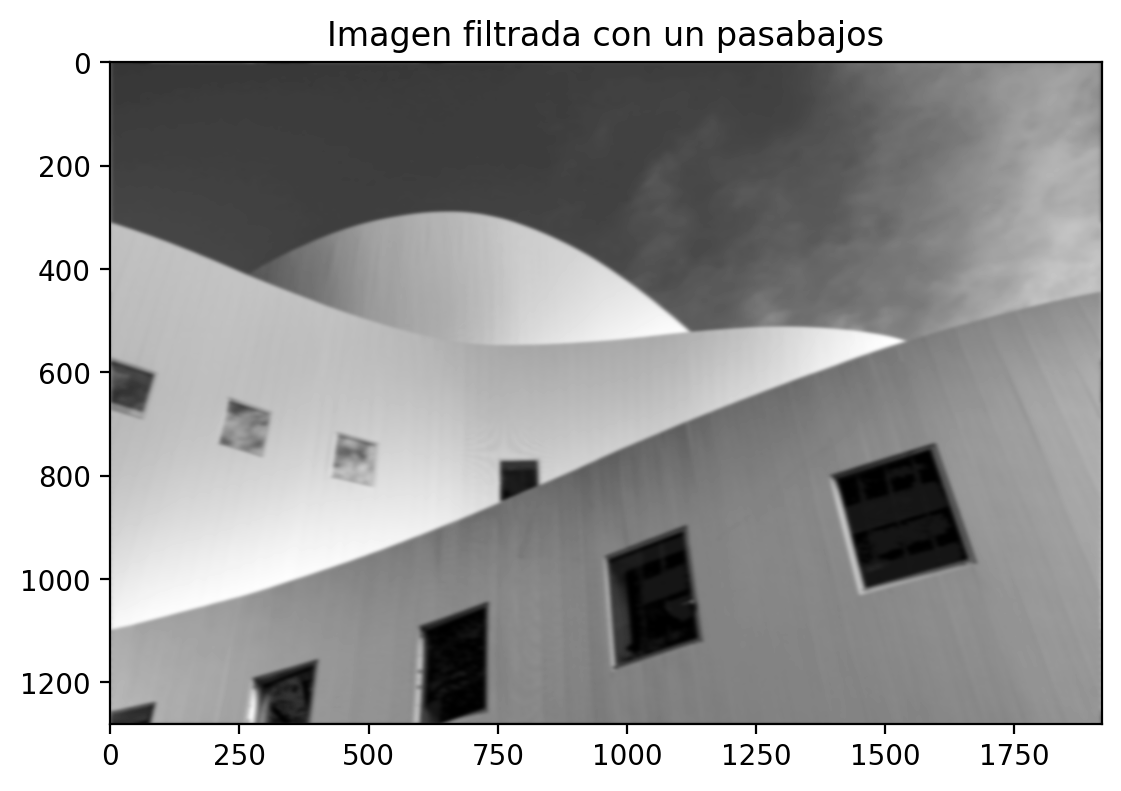

In [9]:
img_arch_lowpass = np.abs(np.fft.ifft2(img_arch_fft_lowpass))
plt.imshow(img_arch_lowpass, cmap='gray')
plt.title('Imagen filtrada con un pasabajos');

Esta imagen debería verse más borrosa. Si está tan borrosa que no entiendes qué estás viendo, escogiste un ```arch_sigma``` muy bajo. Vuelve atrás y escoge uno mayor.

¡Veamos cómo se ve el segmento que estudiamos anteriormente!

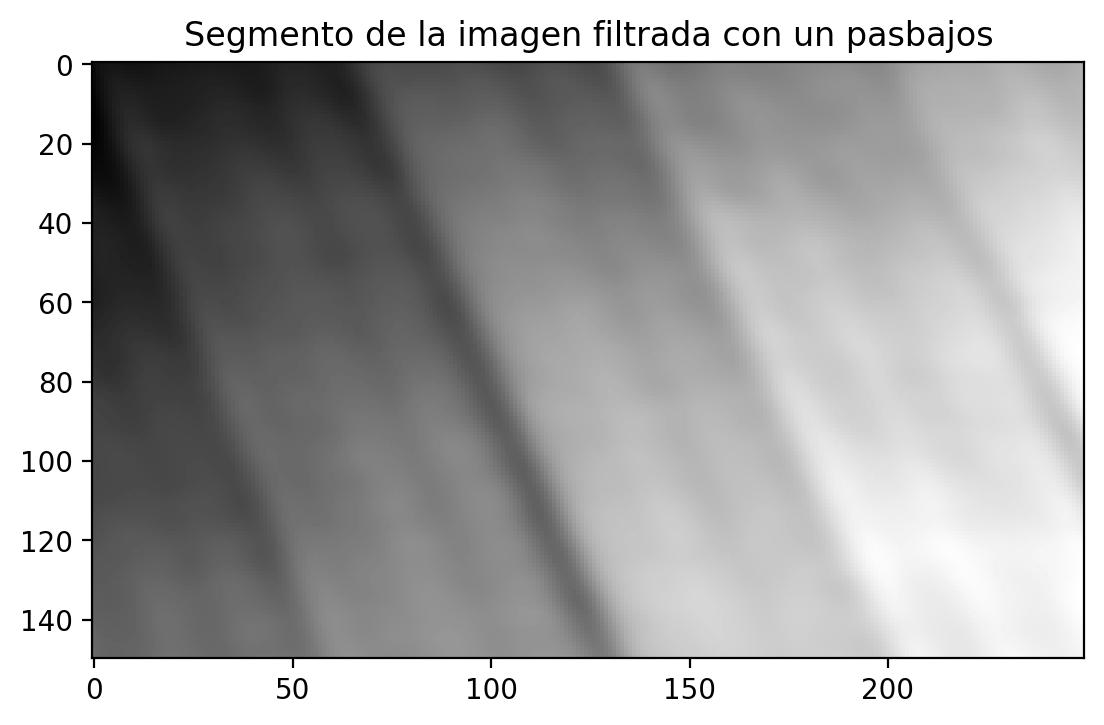

In [10]:
img_lines_lowpass = img_arch_lowpass[550:700, 1650:1900]
plt.imshow(img_lines_lowpass, cmap='gray')
plt.title('Segmento de la imagen filtrada con un pasbajos');

Si escogiste un sigma adecuado, se deberían haber eliminado las líneas de alta frecuencia. Deberías ver una imagen suave con oscilaciones de baja frecuencia.

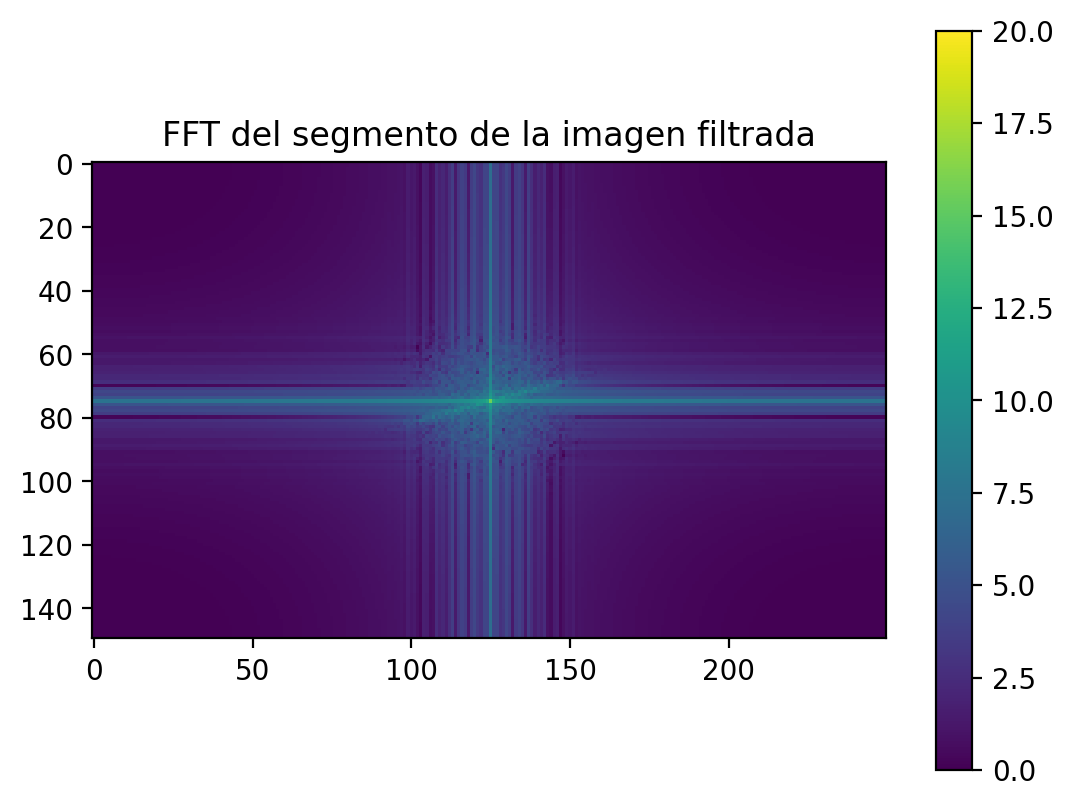

In [11]:
img_lines_fft_lowpass = np.fft.fftshift(np.fft.fft2(img_lines_lowpass))
plt.imshow(np.log(np.abs(img_lines_fft_lowpass)), vmin=0, vmax=20)
plt.title('FFT del segmento de la imagen filtrada')
plt.colorbar();

Si lograste eliminar las líneas, no deberías ver los dos _peaks_ que habíamos notado anteriormente.

### Filtro pasa-altos

Ahora queremos ver cómo se ve la foto luego de aplicarle un pasaaltos. Una forma de lograr esto es como vimos en clases: **restando la imagen filtrada por un pasabajos a la imagen original**. Como quedarán pixeles negativos, debes **tomar el valor absoluto de la imagen resultante**.

Queremos usar un sigma igual a 100. Puedes volver atrás y definir ```arch_sigma = 100``` o definir otro pasabajos e imagen filtrada en la siguiente celda.

Guarda la imagen final en ```img_arch_highpass_1```.

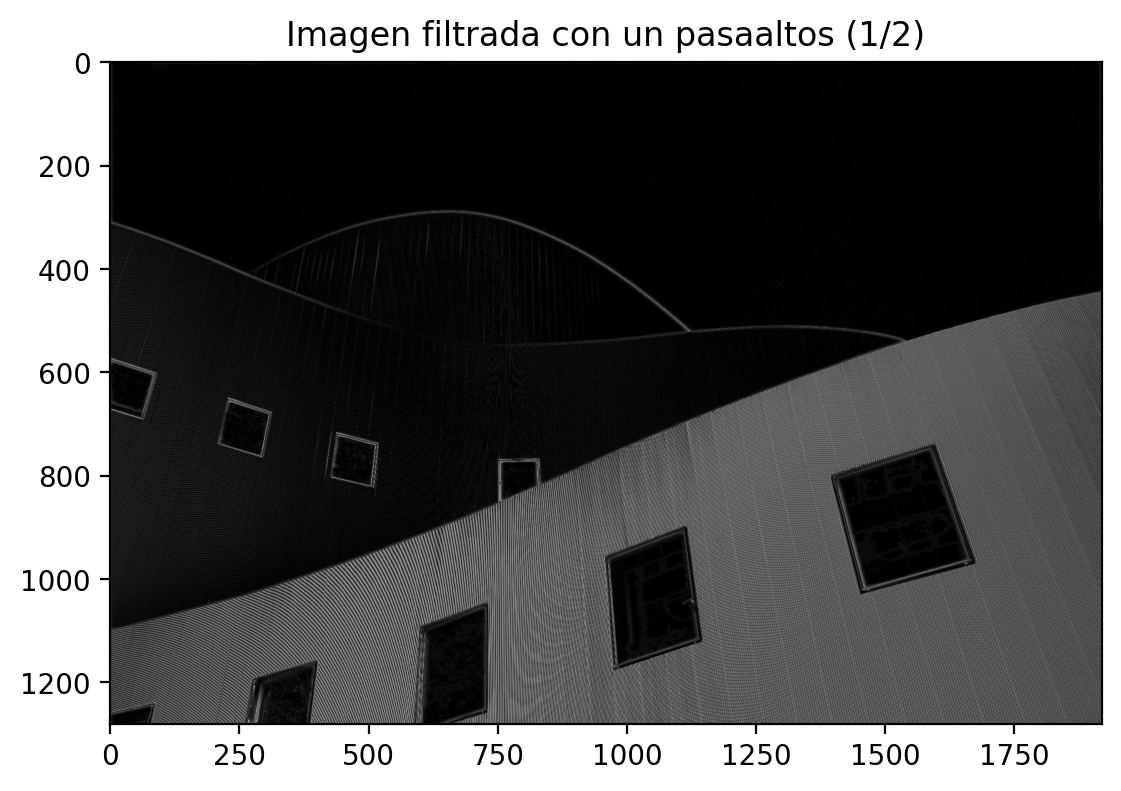

In [12]:
# Define img_arch_highpass_1
img_arch_highpass_1 = np.abs(img_arch - img_arch_lowpass)
plt.imshow(img_arch_highpass_1, cmap='gray')
plt.title('Imagen filtrada con un pasaaltos (1/2)');

Si realizaste el proceso adecuadamente, deberías ver una imagen negra con detalles blancos en algunos lugares. Estás viendo las altas frecuencias de la imagen.

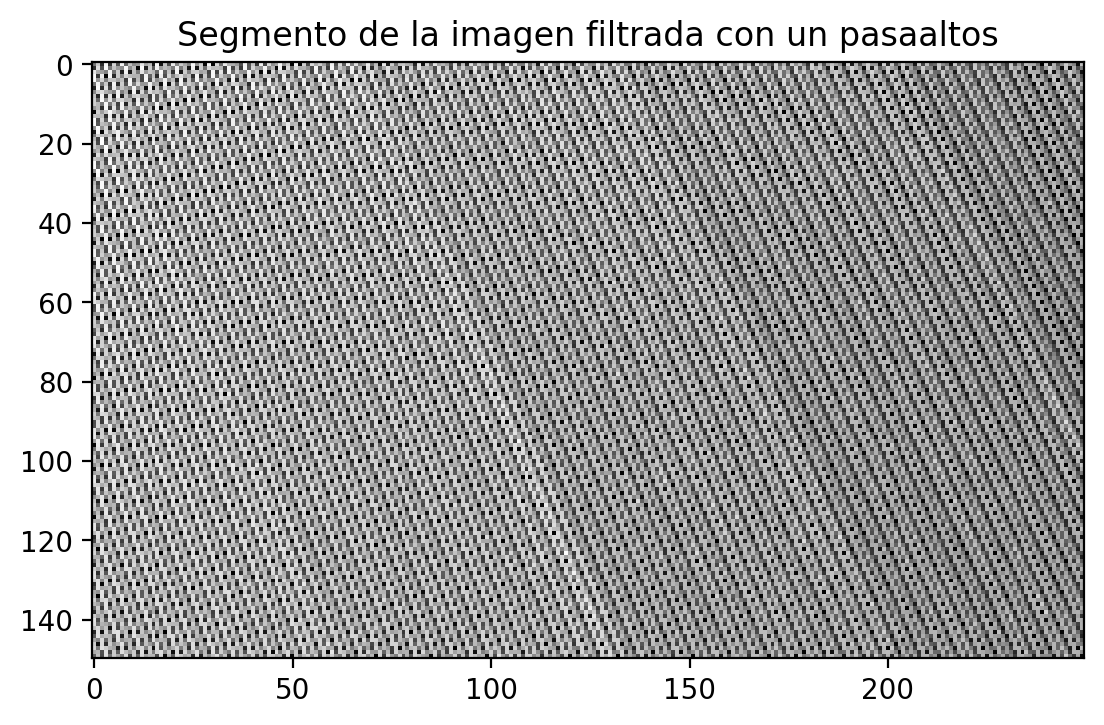

In [13]:
img_lines_highpass = img_arch_highpass_1[550:700, 1650:1900]
plt.imshow(img_lines_highpass, cmap='gray')
plt.title('Segmento de la imagen filtrada con un pasaaltos');

Cuando aplicamos el pasabajos, las líneas desaparecieron del segmento. Ahora que aplicamos un pasaaltos, estas siguen presentes con una apariencia similar a la anterior.

### Filtro pasa altos con Fourier

Al restar la imagen filtrada con un pasabajos de la imagen original, obtuvimos las altas frecuencias de la imagen. Veamos qué obtenemos al aplicarle un filtro pasaaltos en el dominio de la frecuencia a la imagen original.

Anteriormente definimos ```lowpass_mask```, una máscara con valores cercanos a uno en el centro y valores cercanos a cero en los extremos. Ahora queremos lo contrario: una máscara que elimine los valores cercanos al centro (bajas frecuencias) y mantenga los valores en los extremos (altas frecuencias).

**Crea ```highpass_mask``` a partir de ```lowpass_mask```**. El procedimiento es muy simple. También queremos que sea con sigma igual a 100.

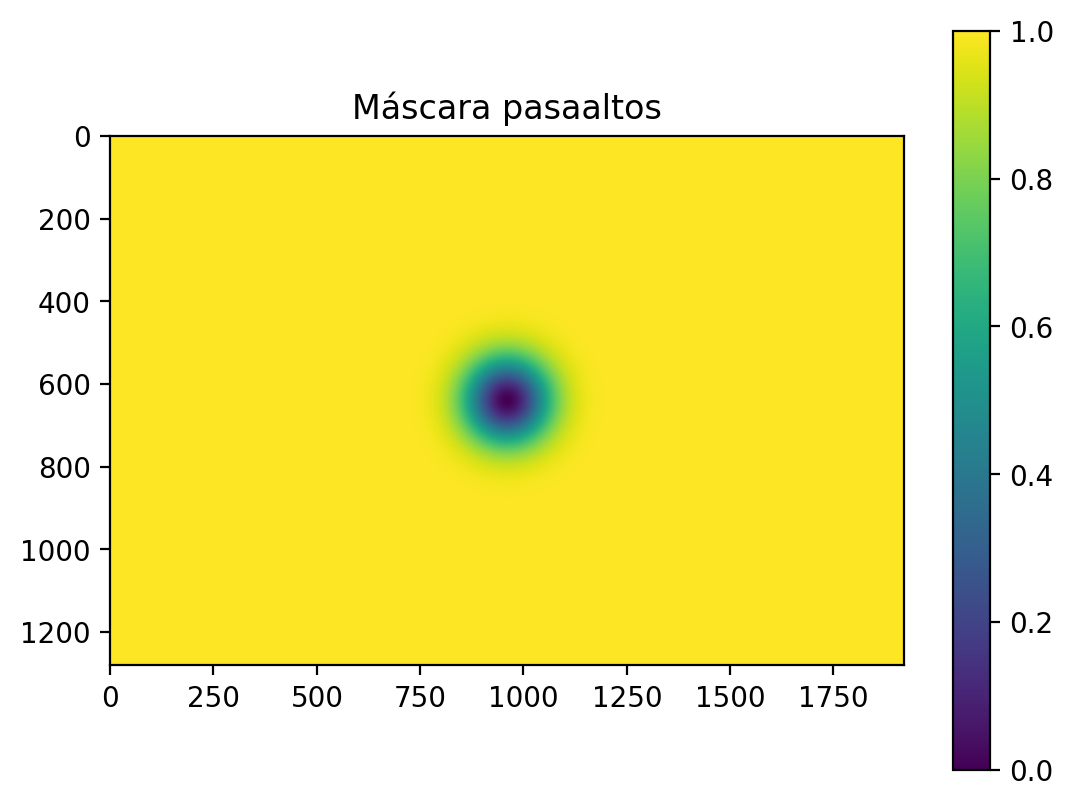

In [14]:
# Define highpass_mask
highpass_mask = 1 - lowpass_mask
plt.imshow(highpass_mask)
plt.title('Máscara pasaaltos')
plt.colorbar();

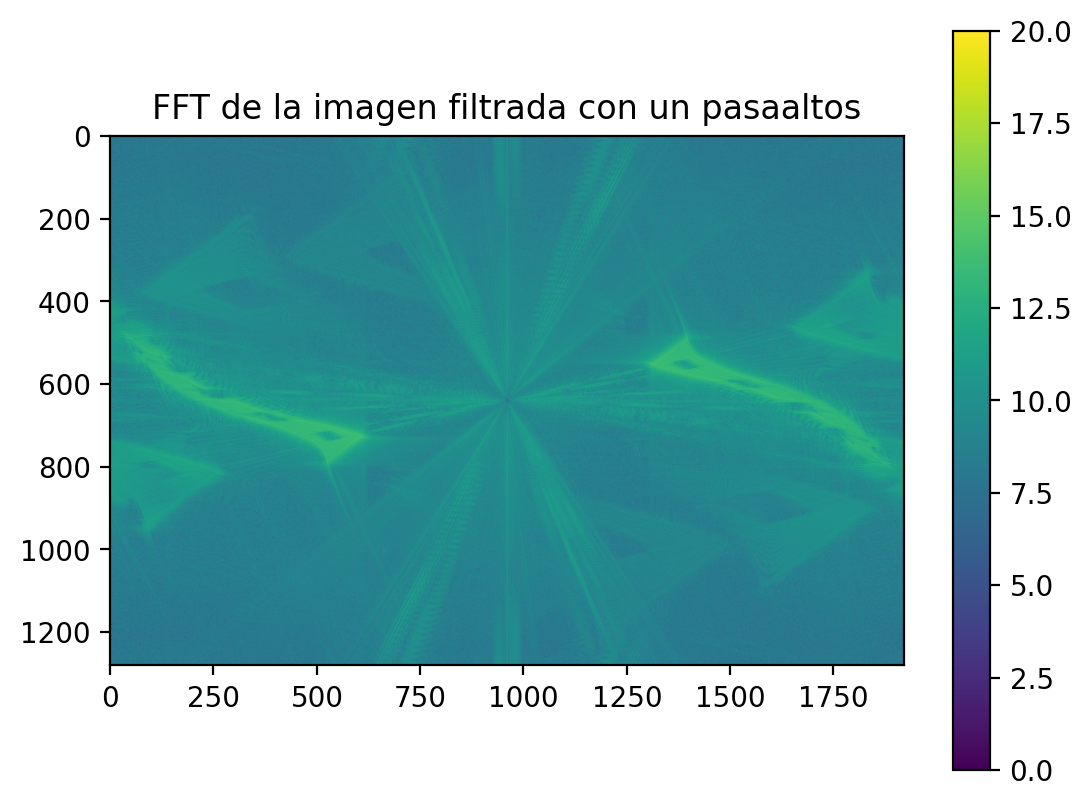

In [15]:
img_arch_fft_highpass = img_arch_fft * highpass_mask
# Hay que hacer una pequeña suma dentro del logaritmo para evitar el 0 del centro
plt.imshow(np.log(np.abs(img_arch_fft_highpass)+0.01), vmin=0, vmax=20)
plt.title('FFT de la imagen filtrada con un pasaaltos')
plt.colorbar();

Es difícil notar la diferencia entre la FFT original y la filtrada debido a la escala logarítmica, pero sí hubo un cambio.

El punto blanco al centro de la imagen corresponde a celdas de valor cero que se indefinen al tomar el logaritmo.

Volvamos al dominio del espacio.

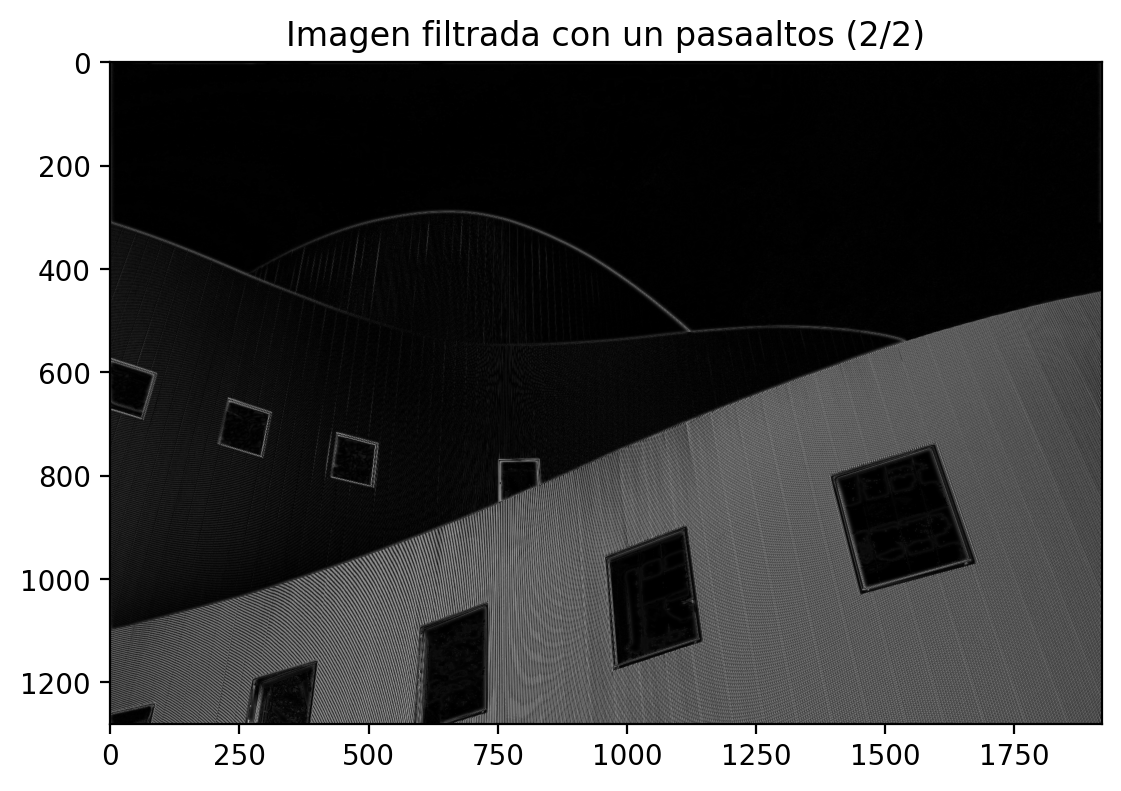

In [16]:
img_arch_highpass_2 = np.abs(np.fft.ifft2((img_arch_fft_highpass)))
plt.imshow(img_arch_highpass_2, cmap='gray')
plt.title('Imagen filtrada con un pasaaltos (2/2)');

¡Llegamos al mismo resultado!

Logramos obtener las frecuencias altas de la imagen a través de dos procedimientos distintos.

## Eliminando frecuencias específicas de una imagen

Carguemos una nueva imagen y estudiémosla.

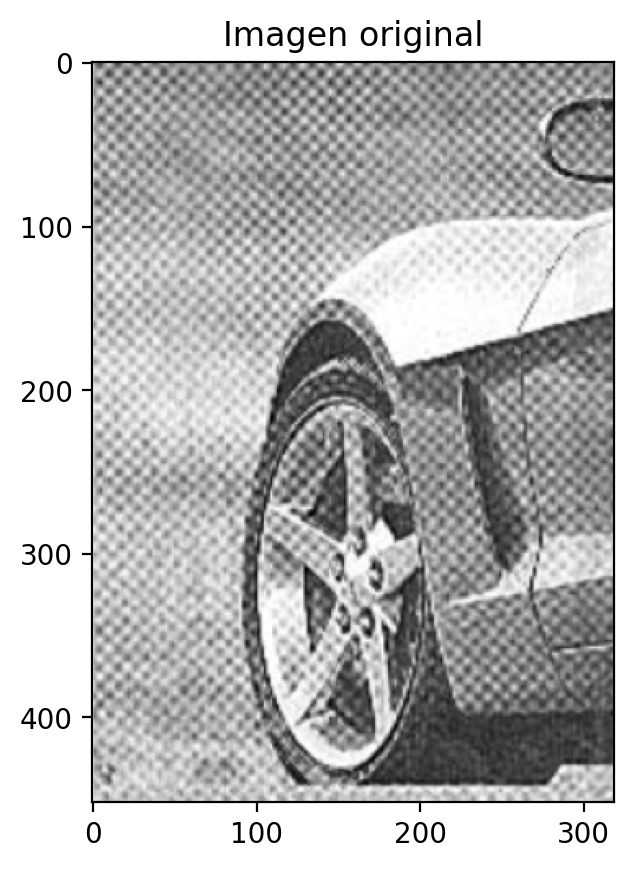

In [17]:
img_car_path = 'car.png'
img_car = cv2.imread(img_car_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(img_car, cmap='gray')
plt.title('Imagen original');

Vemos una gran cantidad de oscilaciones sobre toda la imagen. Eliminémoslas con la ayuda de Fourier.

**Calcula la transformada de Fourier de ```img_car```, aplícale el ```fftshift``` y guárdala en ```img_car_fft```.**

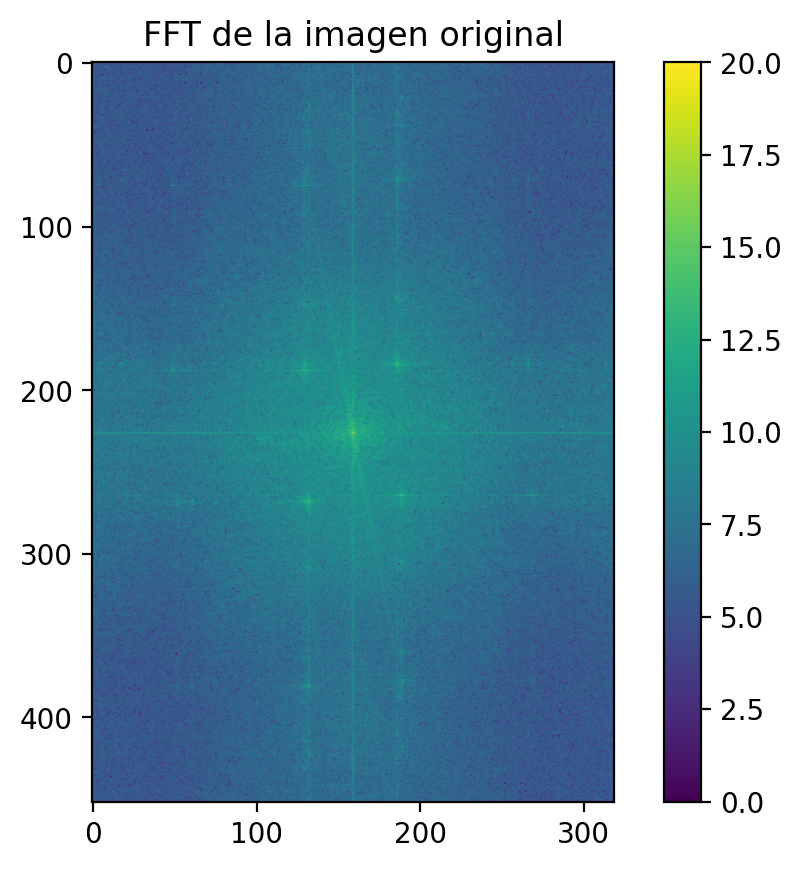

In [18]:
# Define img_car_fft
img_car_fft = np.fft.fftshift(np.fft.fft2(img_car))
plt.imshow(np.log(np.abs(img_car_fft)), vmin=0, vmax=20)
plt.title('FFT de la imagen original')
plt.colorbar();

Vemos cuatro grandes _peaks_ en la FFT de la foto. Estos representan las oscilaciones no deseadas que destacamos anteriormente.

### Eliminando frecuencias no deseadas

Anteriormente eliminamos todas las frecuencias mayores o inferiores a cierto umbral. En este caso solo queremos eliminar unas frecuencias en particular.

Crea una máscara que permita eliminar los cuatro peaks que vimos anteriormente. Utiliza una pequeña Gaussiana de sigma 10 en cada uno de los _peaks_. La ubicación de cada uno de los centros está en la siguiente celda. Puedes comenzar con una matriz de unos y después restar las Gaussianas apoyándote en el código que usamos para generar las máscaras anteriores.

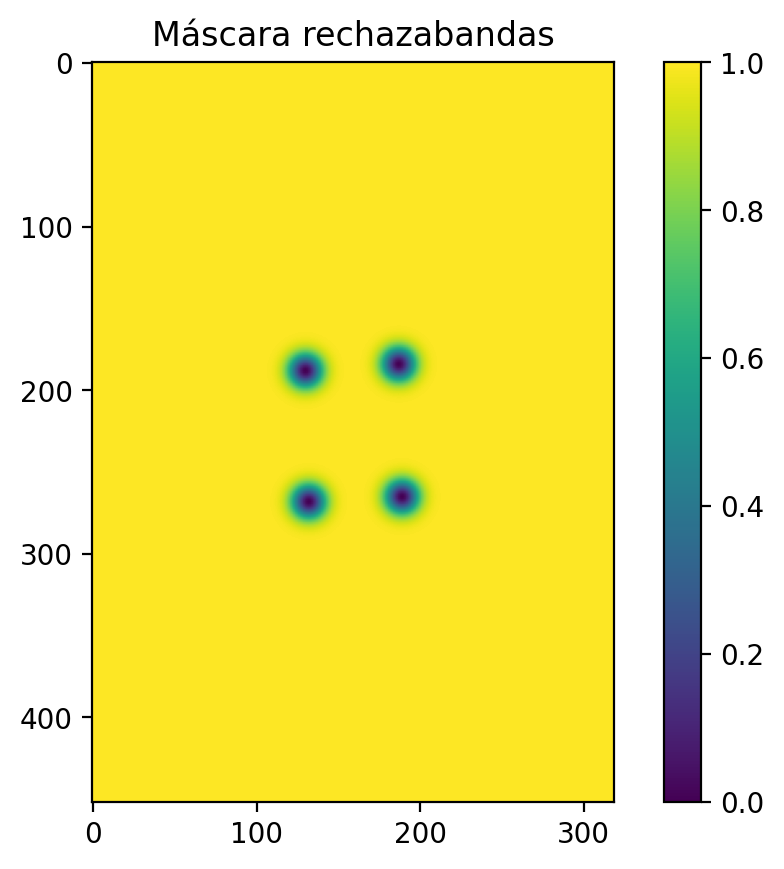

In [19]:
car_sigma = 10
centers = [(188, 130), (184, 187), (268, 132), (265, 189)]
# Define notch_mask
img_car_size_y, img_car_size_x = img_car.shape

grid_x, grid_y = np.meshgrid(np.arange(img_car_size_x), np.arange(img_car_size_y))
top_left_corner = np.exp(-(((grid_y - centers[0][0]) / car_sigma)**2
                        + ((grid_x - centers[0][1]) / car_sigma)**2))
top_right_corner = np.exp(-(((grid_y - centers[1][0]) / car_sigma)**2
                        + ((grid_x - centers[1][1]) / car_sigma)**2))
bottom_left_corner = np.exp(-(((grid_y - centers[2][0]) / car_sigma)**2
                        + ((grid_x - centers[2][1]) / car_sigma)**2))
bottom_right_corner = np.exp(-(((grid_y - centers[3][0]) / car_sigma)**2
                        + ((grid_x - centers[3][1]) / car_sigma)**2))
gaussians = top_left_corner + top_right_corner + bottom_left_corner + bottom_right_corner
notch_mask = np.ones(img_car.shape) - gaussians

plt.imshow(notch_mask)
plt.title('Máscara rechazabandas')
plt.colorbar();

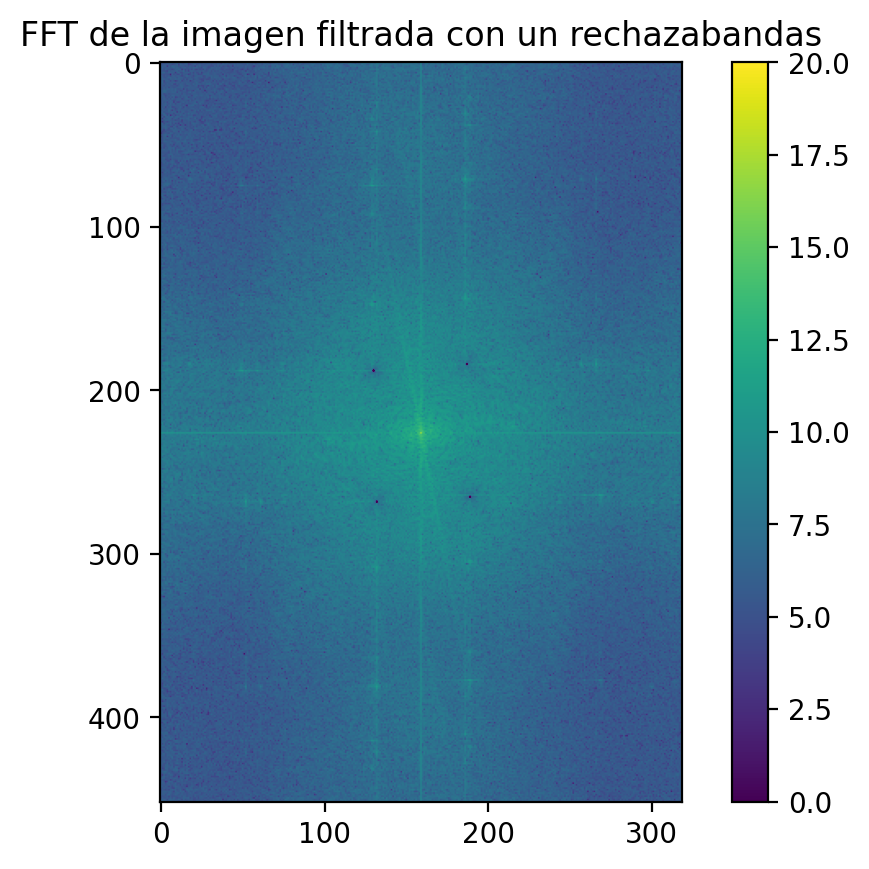

In [20]:
img_car_fft_notch = img_car_fft * notch_mask
plt.imshow(np.log(np.abs(img_car_fft_notch)), vmin=0, vmax=20)
plt.title('FFT de la imagen filtrada con un rechazabandas')
plt.colorbar();

Deberías ver cuatro puntos oscuros donde antes estaban los peaks. ¡Felicitaciones, lograste eliminar las frecuencias no deseadas!

Volvamos al dominio del espacio para ver cómo quedó la imagen.

In [21]:
img_car_notch = np.abs(np.fft.ifft2(np.fft.fftshift(img_car_fft_notch)))
print(f'La intensidad del pixel más oscuro es {img_car_notch.min()}')
print(f'La intensidad del pixel más claro es {img_car_notch.max()}')
print(f'La clase de cada pixel es {img_car_notch.dtype}') 

La intensidad del pixel más oscuro es 20.337933886628008
La intensidad del pixel más claro es 281.5681420036491
La clase de cada pixel es float64


¡Oh no! Al realizar la FFT inversa, nuestra foto quedó con _floats_ en vez de enteros y quedamos con pixeles sobre 255.

**Convierte a 255 el valor de todo pixel mayor a 255**. Luego, convierte el tipo de dato de cada pixel a ```np.uint8```. Almacena el resultado en la misma variable ```img_car_notch```.

In [22]:
# Redefine img_car_notch
img_car_notch[img_car_notch > 255] = 255
img_car_notch = img_car_notch.astype(np.uint8)
print(f'La intensidad del pixel más oscuro es {img_car_notch.min()}')
print(f'La intensidad del pixel más claro es {img_car_notch.max()}')
print(f'La clase de cada pixel es {img_car_notch.dtype}')

La intensidad del pixel más oscuro es 20
La intensidad del pixel más claro es 255
La clase de cada pixel es uint8


¡Excelente! Ahora nuestros pixeles son enteros de 8 bits y están dentro del rango 0 a 255.

Veamos si funcionó nuestra manipulación en el dominio de la frecuencia.

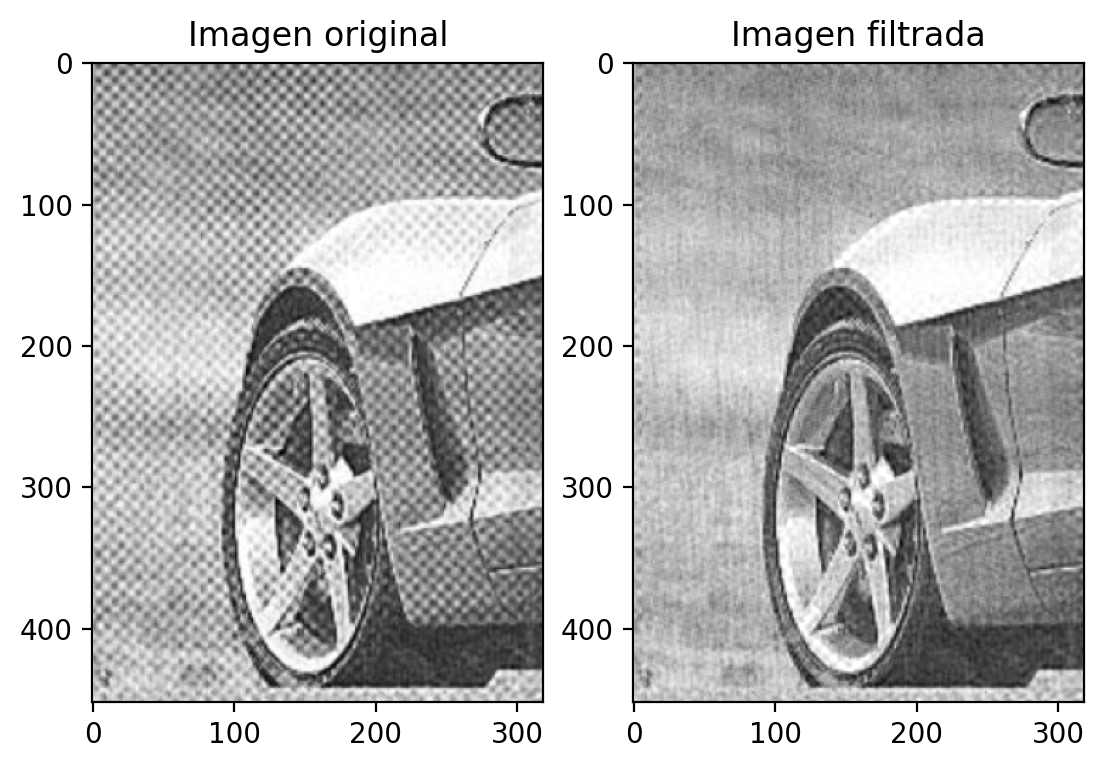

In [23]:
plt.subplot(1, 2, 1)
plt.imshow(img_car, cmap='gray')
plt.title('Imagen original')

plt.subplot(1, 2, 2)
plt.imshow(img_car_notch, cmap='gray')
plt.title('Imagen filtrada');

¡Maravilloso! Mediante la manipulación de la transformada de Fourier de la imagen, lograste eliminar las frecuencias no deseadas de esta. ¡Felicitaciones!